In [11]:
import pandas as pd
data1 = pd.read_csv("E://UIUC/577/milestone/cleaned_data.csv")
data1.drop("reservation_status_date", axis=1, inplace=True)
data1.drop("assigned_room_type.P", axis=1, inplace=True)
data1.drop("reserved_room_type.P", axis=1, inplace=True)

0.5
hotel                             0.005015
lead_time                         0.433230
stays_in_weekend_nights           0.154711
stays_in_week_nights              0.396535
adults                            1.375548
children                          0.420068
babies                            0.515018
is_repeated_guest                 0.023847
previous_cancellations            0.639990
previous_bookings_not_canceled   -0.255150
booking_changes                  -0.874119
days_in_waiting_list             -0.056604
adr                               2.897398
required_car_parking_spaces      -1.951063
total_of_special_requests        -0.592029
arrival_date_month.April          0.002337
arrival_date_month.August        -0.003944
arrival_date_month.December       0.025481
arrival_date_month.February       0.016072
arrival_date_month.July          -0.012888
arrival_date_month.June          -0.018442
arrival_date_month.March         -0.025035
arrival_date_month.May           -0.011587
arrival

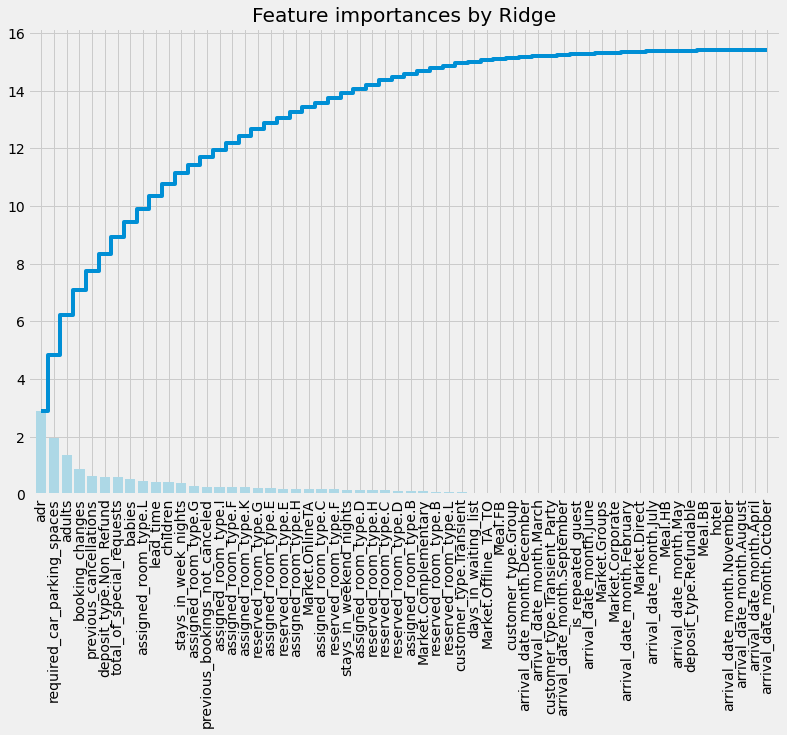

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score


feature = list(data1.columns)
feature.remove('is_canceled')
x_values=data1[feature]
y_values=data1['is_canceled']


model_ridge = RidgeCV(alphas = [.01,.1,.5],normalize=False,gcv_mode='svd',cv=4).fit(x_values, y_values)
print(model_ridge.alpha_)

coef = pd.Series(model_ridge.coef_, index = feature)
print(coef)
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  
names = data1[feature].columns
importances = np.abs(model_ridge.coef_)
feat_names = names
indices = np.argsort(importances)[::-1]  
fig = plt.figure(figsize=(12,8))
plt.title("Feature importances by Ridge")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## LASSO

hotel                            -0.014401
lead_time                         0.421690
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000000
babies                            0.000000
is_repeated_guest                -0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled   -0.000000
booking_changes                  -0.116122
days_in_waiting_list             -0.000000
adr                               0.000000
required_car_parking_spaces      -0.943022
total_of_special_requests        -0.542237
arrival_date_month.April          0.000000
arrival_date_month.August         0.024851
arrival_date_month.December       0.003959
arrival_date_month.February       0.000000
arrival_date_month.July           0.012491
arrival_date_month.June          -0.000000
arrival_date_month.March         -0.017274
arrival_date_month.May           -0.000000
arrival_dat

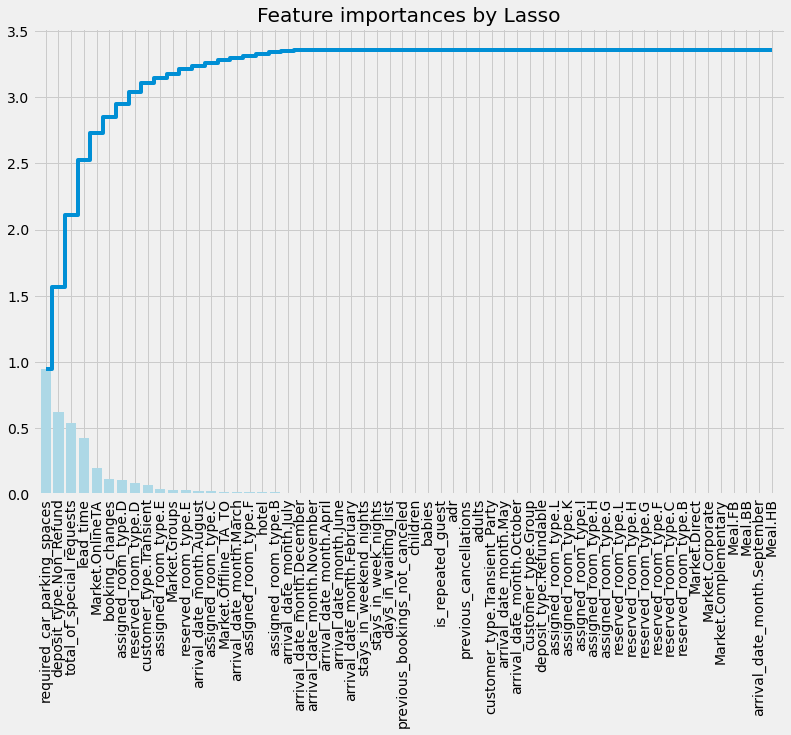

In [13]:
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

model_lasso = LassoCV(alphas = [0.1,1,0.001,0.5]).fit(x_values, y_values)


coef = pd.Series(model_lasso.coef_, index = feature)
print(coef)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  
names = data1[feature].columns
importances = np.abs(model_lasso.coef_)
feat_names = names
indices = np.argsort(importances)[::-1]  
fig = plt.figure(figsize=(12,8))
plt.title("Feature importances by Lasso")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score
lasso_drop = ['assigned_room_type.H','Market.Direct','customer_type.Group','reserved_room_type.B',
'deposit_type.Refundable','reserved_room_type.C','reserved_room_type.F',
'reserved_room_type.G','reserved_room_type.H','reserved_room_type.L','assigned_room_type.L',
'Market.Corporate','assigned_room_type.K',
'assigned_room_type.I','assigned_room_type.G','Market.Complementary','Meal.HB',
'Meal.FB','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies',
'is_repeated_guest','previous_cancellations','previous_bookings_not_canceled','days_in_waiting_list',
'adr','arrival_date_month.April','customer_type.Transient_Party','Meal.BB',
'arrival_date_month.September','arrival_date_month.October','arrival_date_month.February',
'arrival_date_month.May','arrival_date_month.June']
lasso_data = data1.drop(lasso_drop,axis=1)


feature = list(lasso_data.columns)
feature.remove('is_canceled')
x_values=lasso_data[feature]
y_values=data1['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, 
                                                    random_state=0, stratify = y_values)
kappa = []
accuracy = []
f1 = []
#using 4-fold cross-validation
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(X_train,y_train):
    X_train_split, X_test_split=X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train.iloc[train_index], y_train.iloc[test_index]
    LR = LogisticRegression(random_state=0)
    LR.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, LR.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, LR.predict(X_test_split)))
    f1.append(f1_score(y_test_split, LR.predict(X_test_split)))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("f1: {}".format(np.mean(f1)))
print("AUC: {}".format(roc_auc_score(y_test, LR.predict(X_test))))

kappa score: 0.5203642635187251
accuracy: 0.7906115677421611
f1: 0.6651530009939312
AUC: 0.742692513830865


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
y_preditc=LR.predict(X_test)
mse_test=np.sum((y_preditc-y_test)**2)/len(y_test)
rmse_test=mse_test ** 0.5
print("RMSE: {}".format(rmse_test))

RMSE: 0.45904952830477064


## CHI2

hotel                          1.486788e-04
lead_time                      1.522753e-04
booking_changes                2.587560e-05
required_car_parking_spaces    5.491970e-05
total_of_special_requests      1.447462e-04
arrival_date_month.August      2.823965e-07
arrival_date_month.December    1.205723e-06
arrival_date_month.July        8.227540e-08
arrival_date_month.March       9.822707e-06
arrival_date_month.November    9.645311e-06
Market.Groups                  4.901159e-04
Market.Offline_TA_TO           7.801680e-06
Market.OnlineTA                2.428723e-07
reserved_room_type.D           2.277962e-05
reserved_room_type.E           1.702902e-05
assigned_room_type.B           1.677944e-05
assigned_room_type.C           3.385843e-05
assigned_room_type.D           1.545956e-04
assigned_room_type.E           4.744940e-05
assigned_room_type.F           2.456843e-05
deposit_type.Non_Refund        2.425865e-03
customer_type.Transient        5.283458e-05
dtype: float64
chi2 picked 19 va

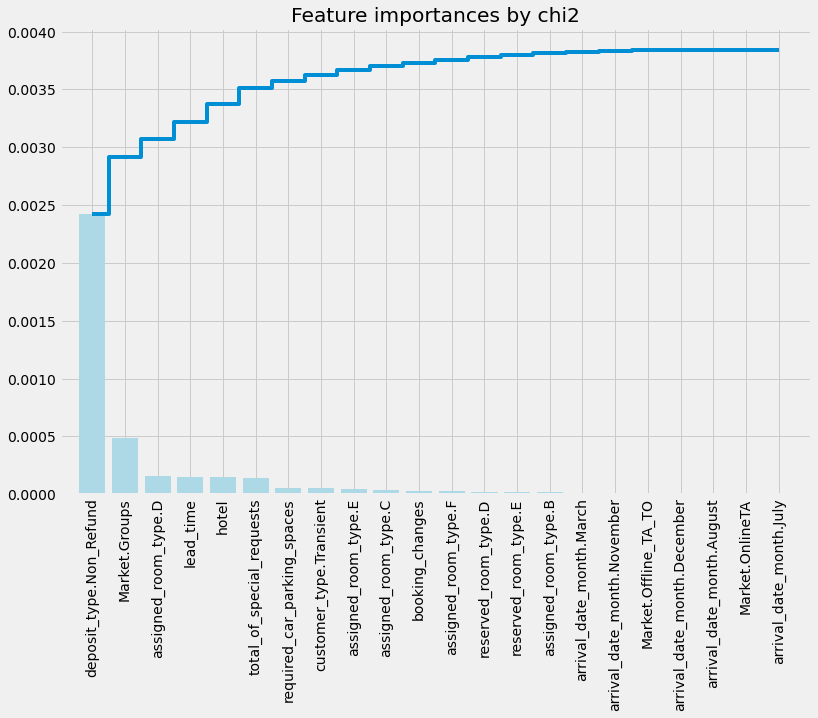

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
 
model_chi2 = SelectKBest(chi2, k='all').fit(x_values, y_values)

coef = pd.Series((model_chi2.scores_)/10**7, index = feature)
print(coef)
print("chi2 picked " + str(sum(coef >= 10**(-6))) + " variables and eliminated the other " +  str(sum(coef < 10**(-6))) + " variables")


import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  
names = data1[feature].columns
importances = np.abs((model_chi2.scores_)/10**7)
feat_names = names
indices = np.argsort(importances)[::-1]  
fig = plt.figure(figsize=(12,8))
plt.title("Feature importances by chi2")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

chi2_drop = ['stays_in_weekend_nights','reserved_room_type.L','reserved_room_type.G','children',
'arrival_date_month.July','assigned_room_type.H']
chi2_data = data1.drop(chi2_drop,axis=1)

feature = list(chi2_data.columns)
feature.remove('is_canceled')
x_values=chi2_data[feature]
y_values=data1['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, 
                                                    random_state=0, stratify = y_values)
kappa = []
accuracy = []
f1 = []
#using 4-fold cross-validation
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(X_train,y_train):
    X_train_split, X_test_split=X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train.iloc[train_index], y_train.iloc[test_index]
    LR = LogisticRegression(random_state=0)
    LR.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, LR.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, LR.predict(X_test_split)))
    f1.append(f1_score(y_test_split, LR.predict(X_test_split)))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("f1: {}".format(np.mean(f1)))
print("AUC: {}".format(roc_auc_score(y_test, LR.predict(X_test))))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

kappa score: 0.5452307682329364
accuracy: 0.8004745714948458
f1: 0.6851764761357675
AUC: 0.7534317930581912


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
y_preditc=LR.predict(X_test)
mse_test=np.sum((y_preditc-y_test)**2)/len(y_test)
rmse_test=mse_test ** 0.5
print("RMSE: {}".format(rmse_test))

RMSE: 0.4500371266429948


## RandomForestClassifier

('hotel', 0.013593464793572284)
('lead_time', 0.203328490441831)
('stays_in_weekend_nights', 0.03522151081480195)
('stays_in_week_nights', 0.057191535415362295)
('adults', 0.017909737788147525)
('children', 0.00780693783831113)
('babies', 0.001172217490333345)
('is_repeated_guest', 0.0024331177705692775)
('previous_cancellations', 0.04014190416350423)
('previous_bookings_not_canceled', 0.00470651809762058)
('booking_changes', 0.024871787942696046)
('days_in_waiting_list', 0.005357208881484483)
('adr', 0.13851756309083113)
('required_car_parking_spaces', 0.024083374040734386)
('total_of_special_requests', 0.07031263235716052)
('arrival_date_month.April', 0.006802930980089066)
('arrival_date_month.August', 0.007581480538254101)
('arrival_date_month.December', 0.005354760923300557)
('arrival_date_month.February', 0.005947437415594804)
('arrival_date_month.July', 0.007630511655354654)
('arrival_date_month.June', 0.006912970660019299)
('arrival_date_month.March', 0.0060942611406818595)
('ar

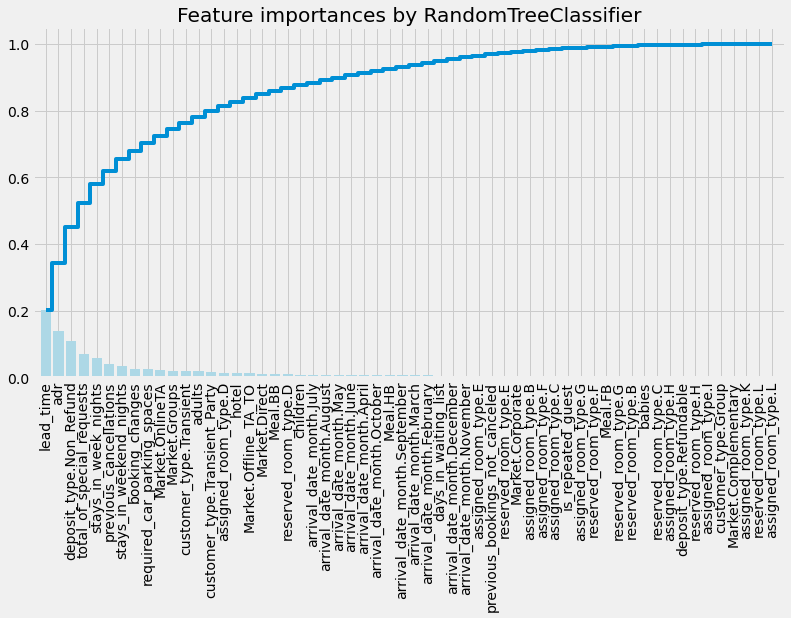

In [19]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
data1 = pd.read_csv("E://UIUC/577/milestone/cleaned_data.csv")
data1.drop("reservation_status_date", axis=1, inplace=True)
data1.drop("assigned_room_type.P", axis=1, inplace=True)
data1.drop("reserved_room_type.P", axis=1, inplace=True)
feature = list(data1.columns)
feature.remove('is_canceled')
x_values=data1[feature]
y_values=data1['is_canceled']
names = data1[feature].columns
clf=RandomForestClassifier(random_state=0)
clf.fit(x_values, y_values) 
for feature in zip(names, clf.feature_importances_):
    print(feature)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

RF_drop = ['reserved_room_type.L','assigned_room_type.L']
RF_data = data1.drop(RF_drop,axis=1)

feature = list(RF_data.columns)
feature.remove('is_canceled')
x_values=RF_data[feature]
y_values=data1['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, 
                                                    random_state=0, stratify = y_values)
kappa = []
accuracy = []
f1 = []
#using 4-fold cross-validation
skFold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in skFold.split(X_train,y_train):
    X_train_split, X_test_split=X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_split, y_test_split=y_train.iloc[train_index], y_train.iloc[test_index]
    LR = LogisticRegression(random_state=0)
    LR.fit(X_train_split, y_train_split)
    kappa.append(cohen_kappa_score(y_test_split, LR.predict(X_test_split)))
    accuracy.append(accuracy_score(y_test_split, LR.predict(X_test_split)))
    f1.append(f1_score(y_test_split, LR.predict(X_test_split)))
#input kappa, % correct, precision, and recall
print("kappa score: {}".format(np.mean(kappa)))
print("accuracy: {}".format(np.mean(accuracy)))
print("f1: {}".format(np.mean(f1)))
print("AUC: {}".format(roc_auc_score(y_test, LR.predict(X_test))))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

kappa score: 0.5491973142769786
accuracy: 0.8019845834568702
f1: 0.6885298942336389
AUC: 0.756680817246591


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
y_preditc=LR.predict(X_test)
mse_test=np.sum((y_preditc-y_test)**2)/len(y_test)
rmse_test=mse_test ** 0.5
print("RMSE: {}".format(rmse_test))

RMSE: 0.4468257638501958
